Churn prediction means detecting which customers are likely to leave a service or to cancel a subscription to a service.

In [1]:
!pip install torch


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Importing the dataset
dataset = pd.read_csv('Churn_Modelling.csv')
# Independent and dependent features
X = dataset.iloc[:, 3:13]
y = dataset.iloc[:, 13]

In [4]:
#Create dummy variables
geography=pd.get_dummies(X["Geography"],drop_first=True)
gender=pd.get_dummies(X['Gender'],drop_first=True)

In [5]:
## Concatenate the Data Frames

X=pd.concat([X,geography,gender],axis=1)

## Drop Unnecessary columns
X=X.drop(['Geography','Gender'],axis=1)

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [6]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [7]:
# Part 2 - Now let's make the ANN!

Sequential, Dense and Dropout layers

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [42]:
#Creating Tensors
# not necessary for the dependent feature to have floating point number
X_train=torch.FloatTensor(X_train)
X_test=torch.FloatTensor(X_test)
y_train=torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)


In [43]:
y_test.type

<function Tensor.type>

In [44]:
# Creating model
class ANN_Model(nn.Module):
  def __init__(self, input_features= 11, hidden1= 20, hidden2 = 20, output_features= 1):
    super().__init__()
    self.f_connected1 = nn.Linear(input_features, hidden1)
    self.f_connected2 = nn.Linear(hidden1, hidden2)
    self.out = nn.Linear(hidden2, output_features)

  def forward(self, x):
    x = F.relu(self.f_connected1(x))
    x = F.relu(self.f_connected2(x))
    x = F.sigmoid(self.out(x))
    return x

In [45]:
# instantiating the model
torch.manual_seed(20)
model = ANN_Model()

In [46]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}")


Parameter name: f_connected1.weight, Shape: torch.Size([20, 11])
Parameter name: f_connected1.bias, Shape: torch.Size([20])
Parameter name: f_connected2.weight, Shape: torch.Size([20, 20])
Parameter name: f_connected2.bias, Shape: torch.Size([20])
Parameter name: out.weight, Shape: torch.Size([1, 20])
Parameter name: out.bias, Shape: torch.Size([1])


Now, the forward propagation is completed.
Doing the backpropation now.

Defining the loss function and the optimizerr

In [47]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [48]:
# Lists to store training and testing loss/accuracy
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

epochs = 400

for i in range(epochs):
    # Training Loss and Accuracy
    model.train()  # Set model to training mode
    y_pred_train = model(X_train).squeeze(1)
    train_loss = loss_function(y_pred_train, y_train)
    train_losses.append(train_loss.item())

    # Convert predictions to binary (0 or 1)
    y_pred_train_class = (y_pred_train >= 0.5).float()
    train_accuracy = accuracy_score(y_train, y_pred_train_class)
    train_accuracies.append(train_accuracy)

    # Test Loss and Accuracy (Validation)
    model.eval()  # Set model to evaluation mode (disables dropout, etc.)
    with torch.no_grad():
        y_pred_test = model(X_test).squeeze(1)
        test_loss = loss_function(y_pred_test, y_test)
        test_losses.append(test_loss.item())

        # Convert predictions to binary (0 or 1)
        y_pred_test_class = (y_pred_test >= 0.5).float()
        test_accuracy = accuracy_score(y_test, y_pred_test_class)
        test_accuracies.append(test_accuracy)

    # Backpropagation and optimizer step for training
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Print every 20 epochs
    if i % 20 == 0:
        print(f"Epoch {i}: Train Loss = {train_loss.item()}, Train Accuracy = {train_accuracy}, Test Loss = {test_loss.item()}, Test Accuracy = {test_accuracy}")


Epoch 0: Train Loss = 0.7065365314483643, Train Accuracy = 0.28825, Test Loss = 0.7058984041213989, Test Accuracy = 0.301
Epoch 20: Train Loss = 0.44255632162094116, Train Accuracy = 0.796, Test Loss = 0.43998730182647705, Test Accuracy = 0.7975
Epoch 40: Train Loss = 0.4162861406803131, Train Accuracy = 0.818625, Test Loss = 0.4170255661010742, Test Accuracy = 0.828
Epoch 60: Train Loss = 0.3944501280784607, Train Accuracy = 0.834375, Test Loss = 0.3945035934448242, Test Accuracy = 0.8315
Epoch 80: Train Loss = 0.36648908257484436, Train Accuracy = 0.848375, Test Loss = 0.3676799535751343, Test Accuracy = 0.847
Epoch 100: Train Loss = 0.3366640508174896, Train Accuracy = 0.865, Test Loss = 0.3389270305633545, Test Accuracy = 0.862
Epoch 120: Train Loss = 0.3269013464450836, Train Accuracy = 0.867875, Test Loss = 0.3352653980255127, Test Accuracy = 0.86
Epoch 140: Train Loss = 0.3206118941307068, Train Accuracy = 0.869625, Test Loss = 0.3325546681880951, Test Accuracy = 0.8615
Epoch 16

In [49]:
# final_losses = [loss.detach().numpy() for loss in final_losses]


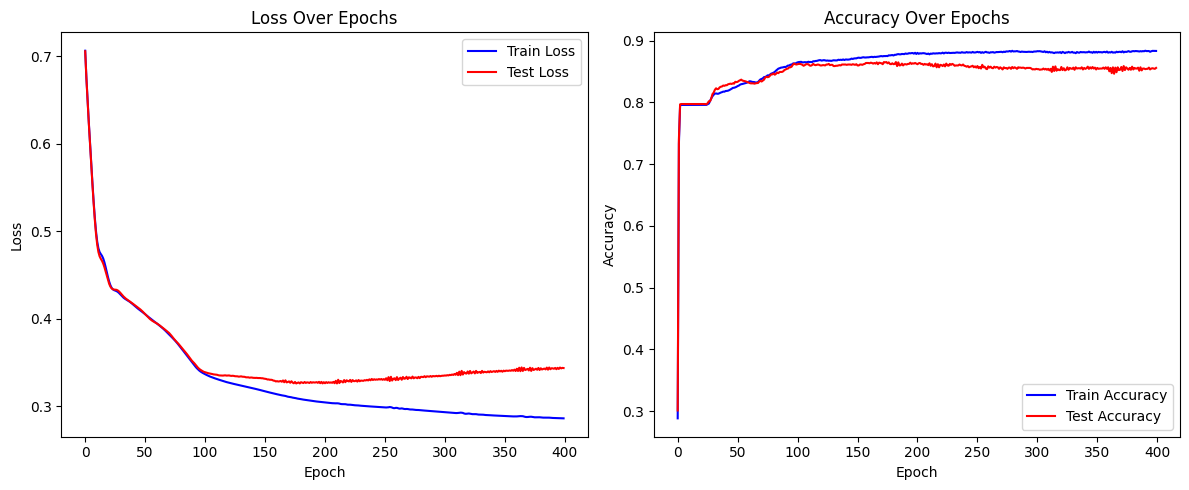

In [50]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns of subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot Train and Test Loss on the first subplot
ax[0].plot(range(epochs), train_losses, label='Train Loss', color='blue')
ax[0].plot(range(epochs), test_losses, label='Test Loss', color='red')
ax[0].set_title('Loss Over Epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot Train and Test Accuracy on the second subplot
ax[1].plot(range(epochs), train_accuracies, label='Train Accuracy', color='blue')
ax[1].plot(range(epochs), test_accuracies, label='Test Accuracy', color='red')
ax[1].set_title('Accuracy Over Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


It is suggesting slight overfitting of the model.

In [52]:
# Make predictions on the X_test data
predictions = []
with torch.no_grad():  # No need to calculate gradients during inference
    y_pred = model(X_test)  # Pass the entire test dataset at once
    y_pred = y_pred.squeeze(1)  # Remove extra dimension if necessary
    # Apply a threshold to get binary predictions
    predictions = (y_pred >= 0.5).float() # Use 0.5 as a threshold for binary classification

# Convert predictions to list for easier viewing
predictions = predictions.numpy().tolist()
print(predictions)  # Display the predictions


[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predictions)
cm

array([[1492,  103],
       [ 185,  220]])

Text(50.722222222222214, 0.5, 'Actual')

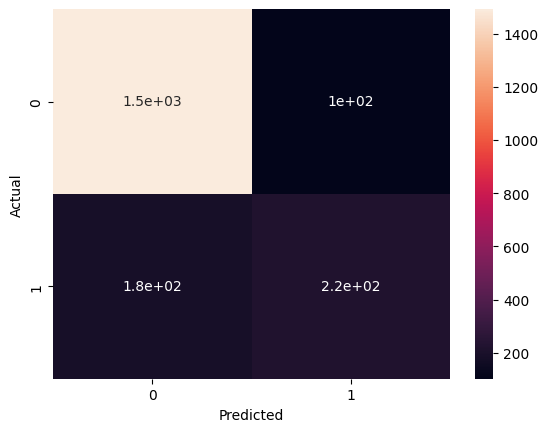

In [55]:
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

seems like model is doing fairly well at identifying the negative class (class "0"), but it struggles more with identifying the positive class (class "1")

In [56]:
score = accuracy_score(y_test, predictions)
score

0.856

In [57]:
# Saving the model
torch.save(model, 'churn.pt')

In [59]:
model = torch.load('churn.pt')
model.eval()

<ipython-input-59-8c5c619ec774>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('churn.pt')


ANN_Model(
  (f_connected1): Linear(in_features=11, out_features=20, bias=True)
  (f_connected2): Linear(in_features=20, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=1, bias=True)
)